In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics 
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from collections import OrderedDict 
from statsmodels.tsa.stattools import adfuller
#from tqdm.autonotebook import tqdm

In [2]:
#agent

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #wealth is the total wealth, P-most probable money, m is the wealth
        #at each time step
        self.m = self.model.T
        
        

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position   = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        lamda = self.model.lamda
        epsilon = random.random()
        if len(cellmates) > 1 :
            other = self.random.choice(cellmates)
            if(other.unique_id != self.unique_id):
                #print(self)
                #print(other)
                #print(self.m, other.m, self.m + other.m)
                xi = self.m
                xj = other.m
                xi_new= round(lamda*xi + epsilon*(1-lamda)*(xi+xj),3)
                xj_new = round(lamda*xj + (1-epsilon)*(1-lamda)*(xi+xj),3)
                other.m = xj_new
                self.m = xi_new
                #print(self.m, other.m, self.m + other.m)
                #print(xi_new, xj_new, xi_new+xj_new)
                #print("break")

    def step(self):
        if self.m > 0:
            self.give_money()
        self.move()
       

In [3]:
#model

#saving propensity = lamda
class BoltzmannWealthModel(Model):

    def __init__(self,T,N,lamda, width=10, height=10):
        self.num_agents = N
        self.T = T
        self.grid = MultiGrid(height, width, True)
        self.lamda = lamda
        self.count = 0
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(agent_reporters={ 'mi':'m'})
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            self.count+=1
            #print("step:{}".format(i))
            self.step()


In [37]:
N = 500 #number of agents
T = 10 #average money per agent
M = N*T #total_money
lamda = 0.4 #saving propensity
steps = 5000 #running for 5000 steps
model = BoltzmannWealthModel(T,N, lamda)
model.run_model(steps)
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)
agent_df['Step'] = agent_df.index


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


# Few Sample plots

Text(0.5, 1.0, 'Wealth Distribution among 500 agents with average money per agent T =10, $\\lambda$ = 0.4')

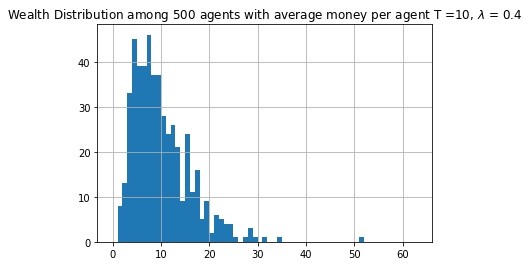

In [38]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
end_wealth = agent_wealth.xs(99, level="Step")["mi"]
end_wealth.hist(bins=range(int(agent_wealth.mi.max()+1)))
plt.title("Wealth Distribution among 500 agents with average money per agent T =10, $\lambda$ = 0.4")

Text(0.5, 1.0, 'Variation of Money for Agent 301 ')

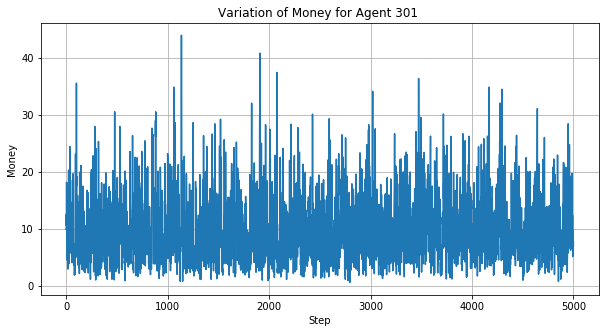

In [57]:
plt.figure(figsize = (10,5))
one_agent_wealth = agent_wealth.xs(301, level="AgentID")
one_agent_wealth.mi.plot()
plt.grid()
plt.ylabel("Money")
plt.title("Variation of Money for Agent 301 ")

In [59]:
#for finding the stationary distribution in 5000 steps

sample = np.linspace(1,5000,5000, dtype = 'int')
data = pd.DataFrame()
df = pd.DataFrame()
tracker = 0

for s in sample:
    P = []
    mT = []
    x = (agent_df.loc[agent_df['Step']==s].mi.reset_index(drop=True))/T
    x = x.to_numpy()
    
    for i in range(len(x)):
        x[i] = round(x[i],2)
    
    count = Counter(x)
    count = OrderedDict(sorted(count.items()))    #Confusion: is this required? When not done majority of the steps turns
    #                                                         out to be stationary (4551 in this particular run)
    for i in count:
        mT.append(i)
        
        
    result = adfuller(mT)
    if(result[1] <= 0.05):
        tracker += 1
        if(tracker==1):
            data['ID'] = np.linspace(1,500,500, dtype = 'int')
            data['Step'] = s
            data['mt'] = x
        else:
            df['ID'] = np.linspace(1,500,500, dtype = 'int')
            df['Step'] = s
            df['mt'] = x
            data = data.append(df, ignore_index= True)
print(tracker)

215


# Number of  stationary distributions in 5000 steps of this run = 215

In [60]:
#stationary distribution is found in the following steps. 
data['Step'].unique()

array([  65,   85,   95,  137,  156,  186,  191,  196,  250,  254,  342,
        344,  351,  434,  435,  447,  474,  500,  526,  531,  546,  589,
        597,  614,  615,  624,  656,  661,  677,  740,  768,  770,  788,
        877,  890,  901,  907,  929,  951,  956,  957, 1006, 1012, 1074,
       1086, 1116, 1130, 1159, 1187, 1213, 1274, 1293, 1305, 1307, 1327,
       1346, 1348, 1381, 1382, 1493, 1590, 1605, 1662, 1669, 1689, 1699,
       1727, 1730, 1787, 1800, 1826, 1845, 1853, 1855, 1902, 1903, 1918,
       1925, 1944, 1951, 1978, 2002, 2076, 2088, 2116, 2137, 2156, 2176,
       2237, 2247, 2249, 2250, 2251, 2255, 2259, 2270, 2309, 2332, 2390,
       2405, 2419, 2434, 2435, 2439, 2451, 2508, 2524, 2529, 2565, 2632,
       2668, 2715, 2731, 2757, 2809, 2811, 2828, 2866, 2868, 2874, 2888,
       2892, 2894, 2911, 2927, 2929, 2969, 2985, 2995, 2997, 3059, 3083,
       3110, 3111, 3139, 3174, 3178, 3185, 3193, 3225, 3275, 3288, 3367,
       3380, 3417, 3418, 3477, 3494, 3516, 3560, 36

0.021145601486802435


Text(0.5, 1.0, '$\\frac{m_i}{T}$ vs Most Probable Money(P) at 4991st step for $\\lambda$ = 0.4')

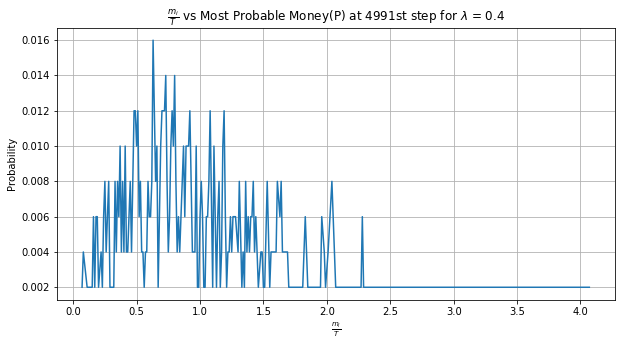

In [64]:
#plot of mi/T vs Most Probable money for all agents in the 4991st step
x = (agent_df.loc[agent_df['Step']==4991].mi.reset_index(drop=True))/T
x = x.to_numpy()
for i in range(len(x)):
    x[i] = round(x[i],2)
P = []
mT = []
count = Counter(x)
count = OrderedDict(sorted(count.items())) 
for i in count:
    P.append(count[i]/500)
    mT.append(i)
result = adfuller(mT)
print(result[1])
plt.figure(figsize=(10,5))
plt.plot(mT,P)
plt.grid()
plt.xlabel("$\\frac{m_i}{T}$")
plt.ylabel("Probability")
plt.title("$\\frac{m_i}{T}$ vs Most Probable Money(P) at 4991st step for $\lambda$ = 0.4")

In [65]:
#finding the probability

steps = data['Step'].unique()
data["P"] = np.nan
for s in steps:
    x = data.loc[data['Step']==s].mt.reset_index(drop=True)
    x = x.to_numpy()
    
    count = Counter(x)
    count = OrderedDict(sorted(count.items())) 
    #print(count)
    
    for i in count:
        P = count[i]/500
        data.loc[data["mt"]==i, "P"] = P
data.head(5)        

,ID,Step,mt,P
0,1,65,2.13,0.002
1,2,65,0.45,0.008
2,3,65,1.82,0.004
3,4,65,0.17,0.002
4,5,65,0.31,0.002


In [66]:
data.to_csv("SD_5000Steps_PAdded_lamda{}.csv".format(lamda))

In [67]:
#finding the mean value of all agents of all stationary distribution
df = data.groupby(['ID'])['mt', 'P'].mean().reset_index()
df = df.sort_values(by=['mt'])
df

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,ID,mt,P
51,52,0.865023,0.006428
123,124,0.869907,0.005991
193,194,0.872512,0.006698
426,427,0.890977,0.006353
269,270,0.894698,0.006428
...,...,...,...
261,262,1.100419,0.005656
84,85,1.101721,0.005628
406,407,1.104651,0.005860
423,424,1.119907,0.005730


Text(0.5, 1.0, '$\\frac{m_i}{T}$ vs Most Probable Money(P) for $\\lambda$ = 0.4')

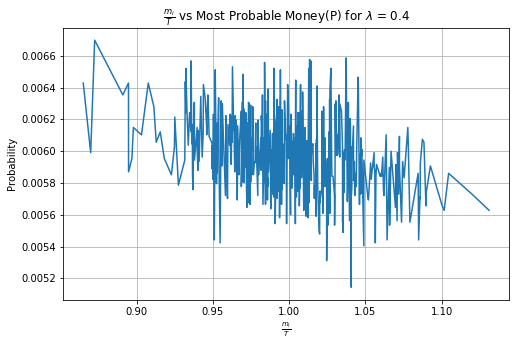

In [68]:
plt.figure(figsize = (8,5))
plt.plot(df['mt'], df['P'])
plt.grid()
plt.xlabel("$\\frac{m_i}{T}$")
plt.ylabel("Probability")
plt.title("$\\frac{m_i}{T}$ vs Most Probable Money(P) for $\lambda$ = 0.4")